# Mental health model

In [17]:
wd = r'D:\natcap\invest-mental-health\data'

import os
os.chdir(wd)
os.getcwd()

import re
import csv
import pandas as pd
import numpy as np
import geopandas as gpd

import rasterio
import matplotlib.pyplot as plt



## Functions

In [18]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    #   for more colormap, see https://matplotlib.org/stable/users/explain/colors/colormaps.html

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)




# Function to plot raster with a legend
def plot_raster_with_legend(raster_path):
    # Open the demand raster
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read the first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        # Get unique values
        unique_values = np.unique(data); print(unique_values)
        # Generate colors for each unique value
        N = len(unique_values)
        min_val = min(unique_values)
        max_val = max(unique_values)

    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(10, 6))
    raster_show = plt.imshow(data, extent=extent,
              cmap=discrete_cmap(N, 'Set2'))  # adjust cmap as needed
    # Overlay the vector (shapefile)
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')  # adjust colors as needed
    fig.colorbar(raster_show, ax=ax, ticks=unique_values, fraction=0.036, pad=0.04)
    plt.clim(min_val-abs(min_val)*0.4, max_val+0.1) # set the color limits.
    ax.axis('off')  # Remove axis ticks and labels
    plt.show()




## Run the function 
# plot_raster_with_legend(files[0])

# Input data

## Shapefiles

In [19]:
# Load the shapefile
shapefile_path = 'cb_2019_us_county_500k_06075_clip.shp'
gdf = gpd.read_file(shapefile_path)




## Land cover 

### Load raw LC layer

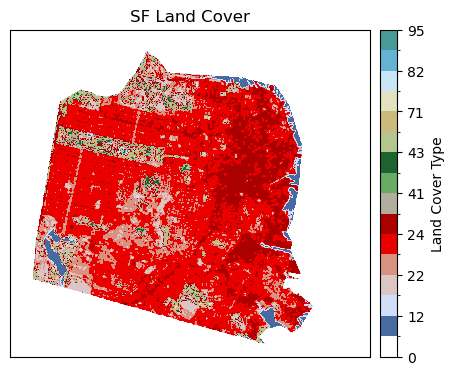

In [20]:

## load lulc map 
lc_img = "nlcd_2019_land_cover_SF.tif"

with rasterio.open(lc_img) as src:
    # Assuming an RGB image
    # Read the raster data as a numpy array
    land_cover = src.read(1)  # Read the first band; adjust if your data has multiple bands

    # Plotting parameters, considering the raster's metadata
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)


# Example color map (adjust the values and classes according to your data)
# NLCD class codes and corresponding colors (from the NLCD legend)
nlcd_class_values = {
    0: (0, 0, 0, 0),    # Transparent background
    11: "#476BA1",      # Open Water
    12: "#D1DEF8",      # Perennial Ice/Snow
    21: "#DEC5C5",      # Developed, Open Space
    22: "#D99282",      # Developed, Low Intensity
    23: "#EB0000",      # Developed, Medium Intensity
    24: "#AB0000",      # Developed, High Intensity
    31: "#B3AC9F",      # Barren Land
    41: "#68AB63",      # Deciduous Forest
    42: "#1C6330",      # Evergreen Forest
    43: "#B5C58F",      # Mixed Forest
    52: "#CCBA7C",      # Shrub/Scrub
    71: "#E2E2C1",      # Herbaceous
    81: "#C8E6F8",      # Hay/Pasture
    82: "#64B3D5",      # Cultivated Crops
    90: "#64ACD7",      # Woody Wetlands
    95: "#499996"       # Emergent Herbaceous Wetlands
}


lc_code_green = [11, 21, 41, 42, 43, 52, 71, 81]
lc_code_blue  = [11, 90, 95]

import matplotlib.colors as mcolors

# Create a color map from the defined colors
nlcd_cmap = mcolors.ListedColormap([nlcd_class_values[key] for key in sorted(nlcd_class_values.keys())])
nlcd_norm = mcolors.BoundaryNorm(sorted(nlcd_class_values.keys()), nlcd_cmap.N)



# Create a plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('SF Land Cover', loc='center')
cax = ax.imshow(land_cover, cmap=nlcd_cmap, norm=nlcd_norm)

# Create a new axes on the right of the current axes for the colorbar
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label('Land Cover Type')

# Remove the x and y ticks and labels
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xlabel('')  # Remove x-axis label if previously set
ax.set_ylabel('')  # Remove y-axis label if previously set

plt.show()



### Reclassify lc

In [21]:
# Open the NLCD GeoTIFF file
with rasterio.open(lc_img) as src:
    # Read the data into a variable
    nlcd_data = src.read(1)  # Assuming the land cover data is in the first band

    # List of developed land cover codes
    developed_codes = [21, 22, 23, 24, 82]

    # Change all developed land cover codes to 0
    for code in developed_codes:
        nlcd_data[nlcd_data == code] = 0

    # Prepare output metadata from source
    out_meta = src.meta



#### Subset lc type(s) of interest

In [22]:
## Only take forest as greenspace -------------------------------------------------------

lc_code_i = [41, 42, 43]    ## Forest
lc_code_i = [71, 81]        ## Grass
lc_code_i = [11]
lc_code_i = lc_code_green   ## Green spaces


delimiter = '_'

lc_code_string = delimiter.join([i if type(i) == float else str(i) for i in lc_code_i])
# print(lc_code_string)

with rasterio.open(lc_img) as src:
    # Read the data into a variable
    lc_i = src.read(1)  # Assuming the land cover data is in the first band
    lc_code_all = np.unique(lc_i[~np.isnan(lc_i)])  # Exclude NaN values for unique count
    print("Unique values:", lc_code_all)

    # List of developed land cover codes
    lc_code_remove = np.setdiff1d(lc_code_all, lc_code_i)
    print(lc_code_remove)

    # Change all developed land cover codes to 0
    for code in lc_code_remove:
        lc_i[lc_i == code] = 0

    # Prepare output metadata from source
    out_meta = src.meta
    nlcd_crs = src.crs  # Get the CRS of the raster


# Path for the modified output file
output_path = lc_img.replace('.tif', '_') + lc_code_string + '.tif'; print(output_path)
# Write the modified data back to a new GeoTIFF file
with rasterio.open(output_path, 'w', **out_meta) as dest:
    dest.write(lc_i, 1)  # Write modified data to the first band



Unique values: [-128   11   21   22   23   24   31   41   42   43   52   71   81   82
   90   95]
[-128   22   23   24   31   82   90   95]
nlcd_2019_land_cover_SF_11_21_41_42_43_52_71_81.tif


### Plot

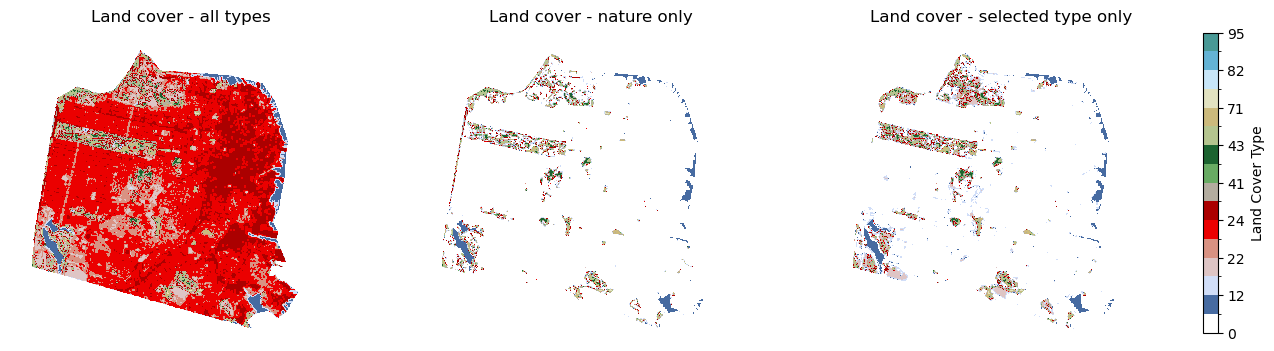

In [23]:
# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot first dataset
img1 = ax1.imshow(land_cover, cmap=nlcd_cmap, norm=nlcd_norm)
ax1.set_title('Land cover - all types')
ax1.axis('off')  # Remove axis ticks and labels

# Plot second dataset
img2 = ax2.imshow(nlcd_data, cmap=nlcd_cmap, norm=nlcd_norm)
ax2.set_title('Land cover - nature only')
ax2.axis('off')  # Remove axis ticks and labels

img3 = ax3.imshow(lc_i, cmap=nlcd_cmap, norm=nlcd_norm)
ax3.set_title('Land cover - selected type only')
ax3.axis('off')  # Remove axis ticks and labels

## Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.6])  # Adjust colorbar position and size: # [left, bottom, width, height]
cbar = fig.colorbar(img1, cax=cbar_ax)
cbar.set_label('Land Cover Type')

plt.show()

### Count by nature LC type

In [24]:
# Step 3: Count Each Land Cover Type

# Unique values and their counts
unique, counts = np.unique(lc_i, return_counts=True)
land_cover_counts = dict(zip(unique, counts))

nlcd_labels = {
    11: "Open Water",
    12: "Perennial Ice/Snow",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Herbaceous",
    81: "Hay/Pasture",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

# Replace codes with labels
land_cover_counts_named = {nlcd_labels[code]: count for code, count in land_cover_counts.items() if code in nlcd_labels}


# Create DataFrame
land_cover_df = pd.DataFrame(list(land_cover_counts_named.items()), columns=['Land Cover Type', 'Count'])

# Display the DataFrame
print(land_cover_df)


         Land Cover Type  Count
0             Open Water   5478
1  Developed, Open Space   9413
2       Deciduous Forest      6
3       Evergreen Forest   3197
4           Mixed Forest    977
5            Shrub/Scrub   1170
6             Herbaceous   2116
7            Hay/Pasture     11


### Load NDVI and LC

GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


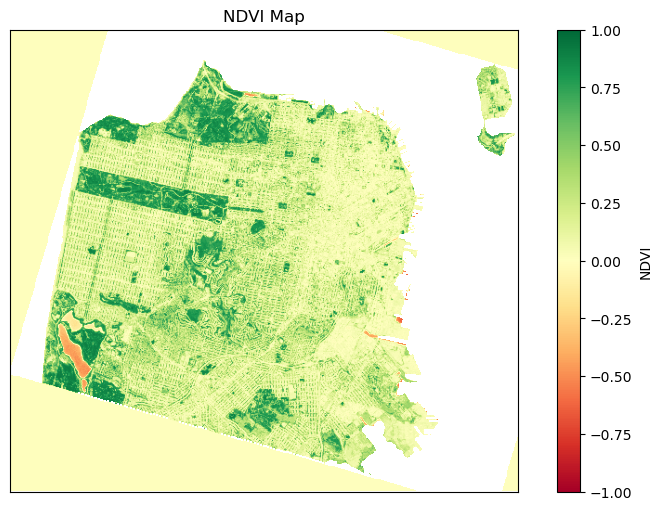

In [38]:
# Read NDVI image
ndvi_path = 'ndvi_s2_075_2019_10m.tif'
land_cover_path = 'nlcd_2019_land_cover_SF_11_21_41_42_43_52_71_81.tif'


with rasterio.open(ndvi_path) as ndvi_src:
    ndvi_data = ndvi_src.read(1)  # Assuming NDVI data is in the first band
    ndvi_profile = ndvi_src.profile
    ndvi_meta = ndvi_src.meta
    ndvi_crs = ndvi_src.crs
    ndvi_transform = ndvi_src.transform

# Read land cover image
with rasterio.open(land_cover_path) as src:
    land_cover_data = src.read(1)  # Assuming land cover data is in the first band
    # Replace 0 values with NaN in the land cover image
    # land_cover_data = np.where(land_cover_data == 0, np.nan, land_cover_data)
    land_cover_profile = src.profile
    lc_meta = src.meta
    lc_crs = src.crs
    lc_transform = src.transform


print(ndvi_crs)
print(src.crs)



# Reproject and resample the land cover image to match the NDVI image
from rasterio.warp import calculate_default_transform, reproject, Resampling

with rasterio.open(ndvi_path) as ndvi_src:
    transform, width, height = calculate_default_transform(
        ndvi_src.crs, ndvi_crs, ndvi_src.width, ndvi_src.height, *ndvi_src.bounds)
    
    ndvi_resampled = np.empty(shape=(lc_meta['height'], lc_meta['width']), dtype=ndvi_data.dtype)
    
    reproject(
        source=ndvi_data,
        destination=ndvi_resampled,
        src_transform=ndvi_src.transform,
        src_crs=ndvi_src.crs,
        dst_transform=lc_transform,
        dst_crs=lc_crs,
        resampling=Resampling.nearest)
    



# Plot the NDVI data
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_resampled, cmap='RdYlGn', vmin=-1, vmax=1)  # Use a colormap suitable for NDVI
plt.colorbar(label='NDVI')
plt.title('NDVI Map')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
plt.grid(False)
# Remove axis ticks and labels in a single step
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()

### Mask NDVI with slected Green space

In [10]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Reproject and resample the land cover image to match the NDVI image
with rasterio.open(land_cover_path) as lc_src:
    transform, width, height = calculate_default_transform(
        lc_src.crs, ndvi_crs, lc_src.width, lc_src.height, *lc_src.bounds)
    
    land_cover_resampled = np.empty(shape=(ndvi_meta['height'], ndvi_meta['width']), dtype=land_cover_data.dtype)
    
    reproject(
        source=land_cover_data,
        destination=land_cover_resampled,
        src_transform=lc_src.transform,
        src_crs=lc_src.crs,
        dst_transform=ndvi_transform,
        dst_crs=ndvi_crs,
        resampling=Resampling.nearest)

# Define the land cover value representing the forest
forest_value = 42  # Adjust this value based on your land cover classification

# Create a mask where the land cover is forest
mask = land_cover_resampled == forest_value

# Create a mask where the land cover is not NaN
mask = land_cover_resampled != 0

# Apply the mask to the NDVI image
# clipped_ndvi = np.where(mask, ndvi_data, np.nan)
clipped_ndvi = np.where(mask, ndvi_data, np.nan)

# Update the metadata to reflect the new data type and number of bands
ndvi_meta.update(dtype=rasterio.float32, count=1)

# Path to save the clipped NDVI image
clipped_ndvi_path = 'ndvi_s2_075_2019_10m_mask_py.tif'

# Save the clipped NDVI image
with rasterio.open(clipped_ndvi_path, 'w', **ndvi_meta) as dst:
    dst.write(clipped_ndvi.astype(rasterio.float32), 1)

print("Clipped NDVI image saved successfully.")

Clipped NDVI image saved successfully.


## Population layer



1.0002633
1000.08453


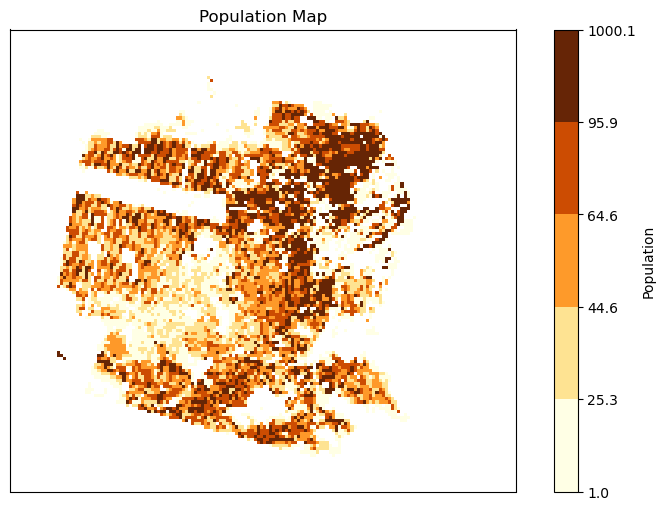

In [55]:
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.colors as colors

# Path to the population raster
population_raster_path = 'usa_ppp_2020_UNadj_constrained_SF_proj_setnull.tif'

# Read the population raster
with rasterio.open(population_raster_path) as src:
    population_data = src.read(1)
    population_meta = src.meta

    # Set pixels with values less than 0 to NaN
    population_data = np.where(population_data < 0, np.nan, population_data)
    # Update the metadata to reflect the new no-data value
    population_meta.update(dtype=rasterio.float32, nodata=np.nan)

    transform = src.transform
    crs = src.crs  # Coordinate reference system
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Calculate the min and max values of the population data
    pop_min = np.min(population_data[np.isfinite(population_data)])  # Ignore NaN or inf values
    pop_max = np.max(population_data[np.isfinite(population_data)])  # Ignore NaN or inf values
    # Calculate quantiles (e.g., 5 quantiles for simplicity)
    quantiles = np.nanquantile(population_data, [0, 0.2, 0.4, 0.6, 0.8, 1.0])

print(pop_min)
print(pop_max)

# Plot the population data
plt.figure(figsize=(10, 6))
norm = colors.BoundaryNorm(boundaries=quantiles, ncolors=256)
plt.imshow(population_data, cmap='YlOrBr', extent=extent, norm=norm)  # Use a colormap suitable for NDVI
plt.colorbar(label='Population')
plt.title('Population Map')
# Remove axis ticks and labels in a single step
plt.xticks([])
plt.yticks([])
# Show the plot
plt.show()




### Convert population raster to point layer

Index(['geometry', 'population'], dtype='object')


<Figure size 1000x800 with 0 Axes>

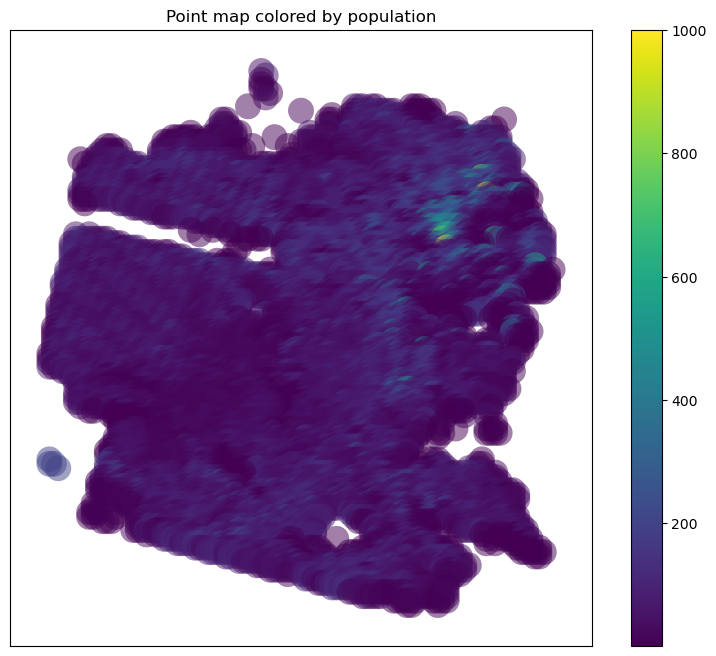

In [70]:
# Find the indices where raster values are greater than 0
rows, cols = np.where(population_data > 0)

# Convert these indices to geographic coordinates
x_coords, y_coords = rasterio.transform.xy(transform, rows, cols, offset='center')

# Extract the population values for the valid pixels
population_values = population_data[rows, cols]

# Create a list of points and their associated population values
points = [Point(x, y) for x, y in zip(x_coords, y_coords)]
point_data = {'geometry': points, 'population': population_values}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(point_data, crs=crs)

# Path to save the point shapefile
output_shapefile_path = 'usa_ppp_2020_UNadj_constrained_SF_proj_setnull_pt_py.shp'
# Save the GeoDataFrame to a shapefile
gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')




# Create a 300m buffer around each point
gdf_copy = gdf
gdf_copy['geometry'] = gdf_copy['geometry'].buffer(300)
output_shapefile_path = 'usa_ppp_2020_UNadj_constrained_SF_proj_setnull_pt_py_300m.shp'
gdf_copy.to_file(output_shapefile_path, driver='ESRI Shapefile')





## Plot the points with colors based on the attribute values
print(gdf.columns)
value_column = 'population'
plt.figure(figsize=(10, 8))
gdf.plot(column=value_column, cmap='viridis', legend=True, markersize=0.001, alpha=0.5, figsize=(10, 8))
plt.title(f"Point map colored by {value_column}")
# Show the plot
plt.xticks([])
plt.yticks([])
plt.show()

# Residential Nature Exposure 

### Reprojection 

In [72]:
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats
from rasterio.mask import mask

# Paths to the buffered shapefile and NDVI raster
buffered_shapefile_path = 'usa_ppp_2020_UNadj_constrained_SF_proj_setnull_pt_py_300m.shp'
ndvi_raster_path = 'ndvi_s2_075_2019_10m_mask_py.tif'


# Read the buffered shapefile
gdf = gpd.read_file(buffered_shapefile_path)
print("Shapefile CRS:", gdf.crs)


# Check if the GeoDataFrame has a CRS
if gdf.crs is None:
    print("GeoDataFrame does not have a CRS. Assigning CRS...")
    # Assign the CRS. Replace 'EPSG:xxxx' with the correct CRS for your data.
    gdf = gdf.set_crs("EPSG:4326")  # Example: setting to WGS 84 (EPSG:4326)

# Read the NDVI raster
with rasterio.open(ndvi_raster_path) as src:
    raster_crs = src.crs
    print("Raster CRS:", raster_crs)



# # Reproject the GeoDataFrame to match the raster CRS if necessary

from osgeo import gdal, osr
import geopandas as gpd


# Path to save the reprojected population raster
ndvi_raster_path_reprojected = 'ndvi_s2_075_2019_10m_reprojected.tif'

# Load the GeoDataFrame to get the target CRS
gdf = gpd.read_file(buffered_shapefile_path)
target_crs_wkt = gdf.crs.to_wkt()  # Get the CRS of the GeoDataFrame in WKT format

# Open the original raster
src_ds = gdal.Open(ndvi_raster_path)

# Get the original CRS and transform
src_proj = src_ds.GetProjection()
src_geotrans = src_ds.GetGeoTransform()

# Define the target spatial reference
target_sr = osr.SpatialReference()
target_sr.ImportFromWkt(target_crs_wkt)

# Get the source spatial reference
source_sr = osr.SpatialReference()
source_sr.ImportFromWkt(src_proj)

# Reproject the raster
gdal.Warp(ndvi_raster_path_reprojected, src_ds, dstSRS=target_sr, format='GTiff')

# Clean up
src_ds = None

print("\n Reprojected raster saved successfully.")



Shapefile CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]

 Reprojected raster saved successfully.


### Zonal stat - Average NDVI within residential area

In [73]:
from osgeo import gdal, ogr, osr
import numpy as np
import geopandas as gpd
from shapely.geometry import box


# Open the raster
raster = gdal.Open(ndvi_raster_path_reprojected)
band = raster.GetRasterBand(1)
nodata_value = band.GetNoDataValue()
if nodata_value is None:
    nodata_value = -9999

# Get raster georeferencing info
transform = raster.GetGeoTransform()
inv_transform = gdal.InvGeoTransform(transform)
raster_srs = osr.SpatialReference(wkt=raster.GetProjection())

# Prepare lists to store results
mean_ndvi = []
max_ndvi = []
min_ndvi = []

# Iterate over each geometry
for geom in gdf.geometry:
    # Create a temporary in-memory layer
    mem_driver = ogr.GetDriverByName('Memory')
    mem_ds = mem_driver.CreateDataSource('')
    mem_layer = mem_ds.CreateLayer('geom', srs=raster_srs, geom_type=ogr.wkbPolygon)
    
    # Add the geometry to the layer
    ogr_geom = ogr.CreateGeometryFromWkb(geom.wkb)
    feature = ogr.Feature(mem_layer.GetLayerDefn())
    feature.SetGeometry(ogr_geom)
    mem_layer.CreateFeature(feature)
    feature = None  # Clear the feature
    
    # Rasterize the geometry to create a mask
    mask_ds = gdal.GetDriverByName('MEM').Create('', raster.RasterXSize, raster.RasterYSize, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(transform)
    mask_ds.SetProjection(raster.GetProjection())
    gdal.RasterizeLayer(mask_ds, [1], mem_layer, burn_values=[1])
    mask_band = mask_ds.GetRasterBand(1)
    
    # Read the data within the masked area
    mask_array = mask_band.ReadAsArray()
    raster_array = band.ReadAsArray()
    
    # Apply the mask to the raster data
    masked_data = np.where(mask_array == 1, raster_array, np.nan)
    
    # Calculate statistics
    if np.any(~np.isnan(masked_data)):
        mean_ndvi.append(np.nanmean(masked_data))
        max_ndvi.append(np.nanmax(masked_data))
        min_ndvi.append(np.nanmin(masked_data))
    else:
        mean_ndvi.append(np.nan)
        max_ndvi.append(np.nan)
        min_ndvi.append(np.nan)
    
    # Clean up
    mask_band = None
    mask_ds = None
    mem_ds = None

# Add the statistics to the GeoDataFrame
gdf['mean_ndvi'] = mean_ndvi
gdf['max_ndvi'] = max_ndvi
gdf['min_ndvi'] = min_ndvi

# Save the results to a new shapefile
zonal_stats_shapefile_path = 'zonal_stats_shapefile.shp'
gdf.to_file(zonal_stats_shapefile_path, driver='ESRI Shapefile')

print("Zonal statistics shapefile saved successfully.")



Zonal statistics shapefile saved successfully.


### Viz pixels/points

Convert Polygons to Points Using Centroids

Point shapefile created successfully from polygon centroids.
Index(['population', 'mean_ndvi', 'max_ndvi', 'min_ndvi', 'geometry'], dtype='object')


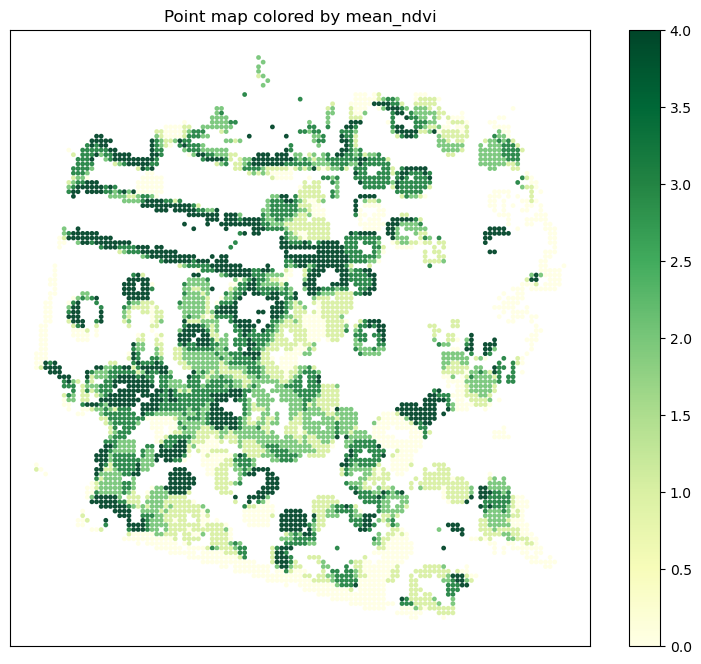

In [91]:
# Calculate the centroids of the polygons
centroids = gdf.centroid

# Create a new GeoDataFrame with the centroids
centroids_gdf = gpd.GeoDataFrame(gdf.drop(columns='geometry'), geometry=centroids, crs=gdf.crs)

# Save the centroids as a new point shapefile
point_shapefile_path = 'zonal_stats_point.shp'
centroids_gdf.to_file(point_shapefile_path)

print("Point shapefile created successfully from polygon centroids.")



## Plot the points with colors based on the attribute values
# Calculate quantiles (e.g., 5 quantiles for quintiles)

print(centroids_gdf.columns)
value_column = 'mean_ndvi'
centroids_gdf['quantile'] = pd.qcut(centroids_gdf[value_column], q=5, labels=False)

# plt.figure(figsize=(10, 8))
# centroids_gdf.plot(column=value_column, cmap='YlGn', legend=True, markersize=6, figsize=(10, 8))

fig, ax = plt.subplots(figsize=(10, 8))
centroids_gdf.plot(column='quantile', cmap='YlGn', legend=True, markersize=6, alpha=0.9, ax=ax)


plt.title(f"Point map colored by {value_column}")
# Show the plot
plt.xticks([])
plt.yticks([])
plt.show()
